In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import torch
from torch.nn import functional as F

from sklearn.metrics import auc
from neurovlm.metrics import recall_curve
from neurovlm.data import data_dir
from neurovlm.retrieval_resources import (
    _load_autoencoder, _load_masker, _proj_head_text_mse,
    _proj_head_image_infonce, _proj_head_text_infonce,
)

In [2]:
# Load pre-trained models
masker = _load_masker()
autoencoder = _load_autoencoder()
proj_head = _proj_head_text_mse()
proj_head_text = _proj_head_text_infonce()
proj_head_image = _proj_head_image_infonce()

# Load neurovault
neurovault_data = torch.load(
    data_dir / "neurovault.pt", weights_only=False
)
df_neuro, df_pubs, _, neuro_clust, _, _, text_emb = neurovault_data.values()

sim_mean = torch.zeros(len(df_pubs))
sim_mean_dec = torch.zeros(len(df_pubs))

latent_image = torch.zeros((len(df_pubs), 384))
latent_text = torch.zeros((len(df_pubs), 384))

latent_image_dec = torch.zeros((len(df_pubs), 384))
latent_text_dec = torch.zeros((len(df_pubs), 384))

for i, doi in enumerate(df_pubs["doi"]):
    with torch.no_grad():

        # Encoded image
        im = autoencoder.encoder(torch.from_numpy(
            neuro_clust[np.where(df_neuro["doi"] == doi)[0]] > 0
        ).to(torch.float32))

        # Decoder model
        tx = F.normalize(text_emb[i], dim=0, eps=1e-8)
        tx_proj = F.normalize(proj_head(tx), dim=0, eps=1e-8)
        latent_text_dec[i] = tx_proj

        sim = (im / im.norm(dim=1)[:, None]) @ tx_proj
        amax = np.argmax(sim)
        sim_mean_dec[i] = sim[amax]
        latent_image_dec[i] = im[amax]

        # Contrastive model
        tx = F.normalize(text_emb[i], dim=0, eps=1e-8)
        tx_proj = F.normalize(proj_head_text(tx), dim=0, eps=1e-8)
        im_proj = F.normalize(proj_head_image(im), dim=1, eps=1e-8)

        sim = im_proj @ tx_proj
        amax = np.argmax(sim)

        latent_text[i] = tx_proj
        latent_image[i] = im_proj[amax]

## Plot Results

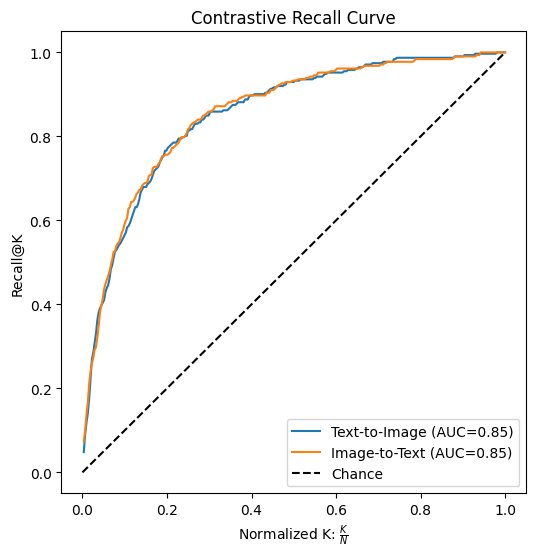

In [5]:
fig, ax = plt.subplots(figsize=(6, 6))

t_to_i, i_to_t = recall_curve(latent_text, latent_image)
x = np.arange(1, len(t_to_i)+1) / len(t_to_i)
ax.plot(x, t_to_i, label=f"Text-to-Image (AUC={round(auc(x, t_to_i), 2)})", color="C0")
ax.plot(x, i_to_t, label=f"Image-to-Text (AUC={round(auc(x, i_to_t), 2)})", color="C1")

ax.set_ylabel("Recall@K")
ax.set_xlabel(r"Normalized K: $\frac{K}{N}$")
ax.set_title("Contrastive Recall Curve")
ax.plot([0, 1], [0, 1], color='k', ls='--', label="Chance")
ax.legend(loc="lower right")
plt.savefig(data_dir / "contrastive_recall.svg")

## Brain-to-Text Generation

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import torch
from torch.nn import functional as F

from sklearn.metrics import auc
from neurovlm.metrics import recall_curve
from neurovlm.data import data_dir
from neurovlm.retrieval_resources import (
    _load_autoencoder, _load_masker, _proj_head_text_mse,
    _proj_head_image_infonce, _proj_head_text_infonce,
)

import torch.nn.functional as F
import torch
import pandas as pd
from pathlib import Path
from transformers import AutoModelForCausalLM, AutoTokenizer

from neurovlm.train import which_device
from tqdm import tqdm
from math import ceil
from neurovlm.models import Specter
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from neurovlm.retrieval_resources import (
    _load_masker, _load_autoencoder, _load_networks, _proj_head_text_infonce
)
from nilearn.plotting import view_img

# Load specter
device = which_device()
specter = Specter("allenai/specter2_aug2023refresh", adapter="adhoc_query", device=device)
proj_head_text = _proj_head_text_infonce().to(device)

There are adapters available but none are activated for the forward pass.


In [8]:
# Load LLM
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side="left")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
model.config.pad_token_id = tokenizer.pad_token_id

# Eval mode and disable gradients
model.eval()
for p in model.parameters():
    p.requires_grad_(False)
torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [4]:
features = np.load(data_dir / "ngram_labels.npy")
with torch.no_grad():
    feature_emb = F.normalize(proj_head_text.to("cpu")(F.normalize(specter(features.tolist()).to("cpu"), dim=1)).cpu(), dim=1)

df_neuro, df_pubs, _, _, _, _, text_emb = torch.load(data_dir / "neurovault.pt", weights_only=False).values()
with torch.no_grad():
    text_emb = F.normalize(proj_head_text.to("cpu")(F.normalize(text_emb, dim=1)).cpu(), dim=1)

In [5]:
autoencoder = _load_autoencoder().to(device)
proj_head_text = _proj_head_text_infonce().to(device)
proj_head_image = _proj_head_image_infonce().to(device)

nv = torch.load(data_dir / "neurovault.pt", weights_only=False)
neuro = nv["neuro_clustered"]
latent_text = nv["text_emb_titles_abstracts"].to(device)
latent_text = F.normalize(latent_text, dim=1)
latent_text = F.normalize(proj_head_text(latent_text), dim=1)

neuro_emb = torch.zeros((len(df_pubs), 384))
imgs_true = torch.zeros((len(df_pubs), 28542))
latent_img = torch.zeros((len(df_pubs), 384))

for i, doi in enumerate(df_pubs["doi"]):
    mask = df_neuro["doi"] == doi
    with torch.no_grad():
        _neuro_emb = F.normalize(proj_head_image(
            autoencoder.encoder(torch.from_numpy(neuro[mask] > 0).float().to(device))
        ), dim=1)

    imax = (_neuro_emb @ latent_text[i]).argmax()
    img = neuro[mask][imax]
    imgs_true[i] = torch.from_numpy(img)
    latent_img[i] = _neuro_emb[imax]
sim = latent_img @ feature_emb.T
features = np.array([features[i] for i in sim.argsort(descending=True, dim=1)[:, :20]])

In [9]:
system_prompt = """
You are a neuroscience editor writing a short wiki-style article from a list of terms. Your job is to provide a predicted title and short summary for each paper.

INPUT: a list of neuroscience terms that came from a paper
OUTPUT: a prediction of the paper's title and abstract

Rules:

1) Title (required): 6–12 words. Make it specific and content-based.
   - Find commonalities among the term list.
   - Use 1–3 of the most informative terms (examples: cognition, network, regions, etc).
   - DO NOT use generic titles like: "Summary", "Overview", "Brain Network Analysis", "A Summary of Terms".
   - Ensure aligns with neuroscience expertise.
   - Do not mention disorders or dieases.
   - Only include cognition, networks, and regions.

2) Summary (3-5 sentence)
   - Expand on the title an explain the neuroscience behind it
   - Include related but not explicitly mentioned topics.

What to include or exclude:
1) Exclude disease or disorder (required)
   - Do not mention disorders or diease.
   - Only include cognition, networks, and regions.
2) Be concrete:
   - Prefer specific mechanisms, pathways, and canonical associations over vague statements.

3) Ignore outlier terms.
   - If a term is too vague/ambiguous/unrelated, ignore it in the main text.

4) No references. Do not mention this prompt.

""".strip()

In [10]:
# Prepare messages
messages = []
for i in range(len(features)):
    user_prompt = ", ".join(features[i])
    messages.append([
        {"role": "system", "content": system_prompt.strip("\n")},
        {"role": "user", "content": user_prompt},
    ])

In [11]:
import torch
from tqdm.notebook import tqdm
import pickle

torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision("high")  # safe speed win on Ampere+

def batch_generate(messages_batch, max_new_tokens=1000):
    # Convert chat messages -> strings once
    prompts = [
        tokenizer.apply_chat_template(m, tokenize=False, add_generation_prompt=True)
        for m in messages_batch
    ]
    enc = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
    ).to(model.device)

    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
        out = model.generate(
            **enc,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.2,
            top_p=0.9,
            top_k=50,
            repetition_penalty=1.1,
            use_cache=True,
        )

    # Decode
    gen = out[:, enc["input_ids"].shape[1]:]
    return tokenizer.batch_decode(gen, skip_special_tokens=True)

In [10]:
# Generate
batch_size = 16
summaries = []
for i in tqdm(range(0, len(messages), batch_size)):
    summaries.extend(batch_generate(messages[i:i+batch_size], max_new_tokens=1000))

# Save
with open(data_dir / "generated_summaries_neurovault.pkl", "wb") as f:
    pickle.dump(summaries, f)

  0%|          | 0/20 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

In [11]:
df_pubs["brain_to_text_summary"] = summaries
df_pubs["brain_to_text_summary"] = df_pubs["brain_to_text_summary"].str.strip()
df_pubs["brain_to_text_summary"] = df_pubs["brain_to_text_summary"].str.replace("**Title:**", "").str.replace("**Summary:**", "").str.replace("\n\n ", " [SEP] ").str.replace('"', "").str.strip()
df_pubs.to_csv(data_dir / "neuro_vault_brain_to_text.csv", index=False)

In [12]:
df_pubs

,doi,title,abstract,brain_to_text_summary
0,10.1111/cdev.12630,Neural Reactivity to Emotional Faces May Media...,Reactivity to others' emotions not only can re...,Neural Mechanisms Underlying Proactive Control...
1,10.7554/eLife.15192,Instructed knowledge shapes feedback-driven av...,Socially-conveyed rules and instructions stron...,Decoding Pain Perception through Interactions ...
2,10.1073/pnas.0602659103,Modulation of competing memory systems by dist...,Different forms of learning and memory depend ...,Prefrontal Cortical Regions Modulate Executive...
3,10.1073/pnas.1518377113,Neural correlates of the LSD experience reveal...,"Lysergic acid diethylamide (LSD), the prototyp...",Decoding Episodic Memory Retrieval through Hip...
4,10.1038/s41598-017-09744-7,Intrinsic brain connectivity after partial sle...,Sleep deprivation has been reported to affect ...,Decoding Self-Referential Processing within th...
...,...,...,...,...
171,10.1016/j.neuroimage.2022.119149,Atlas of type 2 dopamine receptors in the huma...,The dopamine system contributes to a multitude...,Decoding Reward Processing in Ventral Striatal...
172,10.1016/j.appet.2023.106630,The effect of cognitive load on preference and...,Distracted eating can cause overconsumption. W...,Decoding Motor Control Mechanisms in the Premo...
173,10.1038/s41593-024-01772-7,A potential target for noninvasive neuromodula...,Neuromodulation trials for the treatment of po...,Neural Correlates of Visuospatial Attention du...
174,10.1212/WNL.0000000000213507,Amyloid and Tau Pathology in Cognitively Unimp...,Female sex and a parental history of Alzheimer...,Decoding Visual Perception through Ventral and...
